In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.patches import Circle, PathPatch, Rectangle
import time
import matplotlib.colors as mcolors
import glob 
import os.path
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.optimize import minimize

# define DAQ and other parameters
tscale = (8.0/4096.0)     # = 0.002 µs/sample, time scale
vscale = (2000.0/16384.0) # mV/ADCC

n_sipms = 32
n_channels = n_sipms+1 # includes sum
d_between_SiPM_center_x = 1.23 # cm
d_between_SiPM_center_y = 1.14 # cm
    
# define top, bottom channels
n_top = int((n_channels-1)/2)
top_channels=np.array(range(n_top),int)
bottom_channels=np.array(range(n_top,2*n_top),int)

pl.rcParams.update({'xtick.direction': 'in'})
pl.rcParams.update({'ytick.direction': 'in'})

def load_run(data_dirs,rq_file='rq_filtered_alphas_newSPE.npy'):
    """
    return a dict for a single run
    """
    data = {}
    listrq = np.load(data_dirs+'/'+rq_file)
    rq_names = listrq.files
    for key in rq_names:
        #locals()[key] = (listrq[key])
        data[key] = np.copy( (listrq[key]) )
    listrq.close()
    # --- derived RQ keys go here -----
    
    # Centroid calculations
    fudge = 2.35
    data['center_bot_x_d'] = data['center_bot_x'] * fudge # d_between_SiPM_center_x/2
    data['center_bot_y_d'] = data['center_bot_y'] * fudge #d_between_SiPM_center_y/2
    data['center_bot_r_d'] = np.sqrt(np.power(data['center_bot_x_d'],2)+np.power(data['center_bot_y_d'],2))
    data['center_top_x_d'] = data['center_top_x'] * fudge #d_between_SiPM_center_x/2
    data['center_top_y_d'] = data['center_top_y'] * fudge #d_between_SiPM_center_y/2
    data['center_top_r_d'] = np.sqrt(np.power(data['center_top_x_d'],2)+np.power(data['center_top_y_d'],2))

    # Other rq's
    data['p_fall_time'] = (data['p_afs_99'] - data['p_afs_50'])*2/1000
    data['p_t_rise'] = tscale*(data['p_afs_50']-data['p_afs_2l'])
    
    data['p_coinc'] = np.count_nonzero(data['p_max_height_ch']>0.013,axis=2) # coincidence level
    
    # Basic cuts
    data['valid_pulse'] = data['p_area'] > 0.1
    data['s1'] = ((data['p_class'] == 1) + (data['p_class'] == 2))*data['valid_pulse']
    data['s2'] = ((data['p_class'] == 3) + (data['p_class'] == 4))*data['valid_pulse']

    rad_cut = 999
    data['s1_rad'] = data['s1']*(data['center_top_r_d'] < rad_cut)
    data['s2_rad'] = data['s2']*(data['center_top_r_d'] < rad_cut)
    
    # ---------------------------------
    return data

def fetch_data_from_list(run_list,rq_file='rq_filtered.npy'):
    """
    given list of strings for each run
    load all the rqs into a dict
    """
    run_ct = 0
    full_dict = {}
    for r in run_list:
        if os.path.exists(r+'/'+rq_file):
            print('loading data from {:s}'.format(r))
            print(' ')
            data = load_run(r,rq_file=rq_file)
            run_ct = run_ct+1
        else:
            print(r,' does not seem to exist. skipping.')
            print(' ')
            continue
        for key in data:
            if key in full_dict:
                if key=='n_events':
                    full_dict[key] += data[key][()]
                else:
                    #print(key)
                    full_dict[key] = np.concatenate([full_dict[key],data[key]])
            else:
                full_dict[key] = data[key]
        del data
    print("loaded ",run_ct," datasets")
    return full_dict

def build_ss_dict(data):
    """
    create dict of only SS events
    """
    ss_dict = {}
    n_events = data['n_events'][()]
    ss_pass = np.zeros(n_events,dtype='int')
    ss_s1_area = np.zeros(n_events)
    ss_s2_area = np.zeros(n_events)
    ss_s2b_area = np.zeros(n_events)
    ss_sum_s2_area = np.zeros(n_events) 
    ss_dt = np.zeros(n_events)
    ss_s1_top_x = np.zeros(n_events)
    ss_s1_top_y = np.zeros(n_events)
    ss_s1_top_r = np.zeros(n_events)
    ss_s2_top_x = np.zeros(n_events)
    ss_s2_top_y = np.zeros(n_events)
    ss_s2_top_r = np.zeros(n_events)
    ss_s1_width = np.zeros(n_events)
    ss_s2_width = np.zeros(n_events)
    ss_s1_tba = np.zeros(n_events)
    ss_s2_tba = np.zeros(n_events)
    ss_s1_coinc = np.zeros(n_events)
    ss_right_area = np.zeros(n_events)
    ss_n_s1 = np.zeros(n_events)
    ss_n_s2 = np.zeros(n_events)

    for i in range(n_events):
        ss_bool = False # assume not SS by default
        # find pulse locations:
        S2locs = np.nonzero(data['s2'][i,:])[0] #location of all S2s
        S1locs = np.nonzero(data['s1'][i,:])[0] #location of all S1s

        # number of each type:
        nS2 = len(S2locs)
        nS1 = len(S1locs)

        if nS2>0 and nS1>0: #later this requirement can become more strict

            # find location of "the" S1 and S2
            # for now defined as the biggest of each type:
            maxS2loc = S2locs[np.argmax(data['p_area'][i,S2locs])]
            maxS1loc = S1locs[np.argmax(data['p_area'][i,S1locs])]

            # S1 must preceed S2
            if maxS1loc<maxS2loc: 
                ss_bool = True
            else:
                ss_bool = False

        else: # not an SS
            ss_bool = False
        
        # ---------- end of SS logic --------
        
        # fill all SS events' RQs here
        if ss_bool:
            ss_pass[i] = int(1)
            ss_s1_area[i] = data['p_area'][i,maxS1loc]
            ss_s2_area[i] = data['p_area'][i,maxS2loc]
            ss_s2b_area[i] = data['p_area_bottom'][i,maxS2loc]
            ss_sum_s2_area[i] = np.sum(data['p_area'][i,S2locs]) 
            ss_dt[i] = ( data['p_afs_2l'][i,maxS2loc] - data['p_afs_2l'][i,maxS1loc] ) * tscale
            ss_s1_top_x[i] = data['center_top_x_d'][i,maxS1loc]
            ss_s1_top_y[i] = data['center_top_y_d'][i,maxS1loc]
            ss_s1_top_r[i] = data['center_top_r_d'][i,maxS1loc]
            ss_s2_top_x[i] = data['center_top_x_d'][i,maxS2loc]
            ss_s2_top_y[i] = data['center_top_y_d'][i,maxS2loc]
            ss_s2_top_r[i] = data['center_top_r_d'][i,maxS2loc]
            ss_s1_width[i] = data['p_width'][i,maxS1loc]*2/1000
            ss_s2_width[i] = data['p_width'][i,maxS2loc]*2/1000
            ss_s1_tba[i] = data['p_tba'][i,maxS1loc]
            ss_s2_tba[i] = data['p_tba'][i,maxS2loc]
            ss_s1_coinc[i] = data['p_coinc'][i,maxS1loc]
            ss_right_area[i] = data['right_area'][i]
            ss_n_s1[i] = nS1
            ss_n_s2[i] = nS2
                
    # done with event loop
    
    # trim zeros with a basic requirement.
    # can also choose to not do this for access to 
    # other RQs later as well
    doCut = True
    
    if doCut:
        ss_base_cut = np.asarray(np.ones_like(ss_s1_area),dtype=bool) #(ss_s1_area>0)
    #else:
    #    ss_base_cut = np.ones(n_events,dtype='int') # warning: this doesn't work!
    
    ss_dict['pass'] = ss_pass # this one doesn't get the cut
    ss_dict['s1_area'] = ss_s1_area[ss_base_cut]
    ss_dict['s2_area'] = ss_s2_area[ss_base_cut]
    ss_dict['s2b_area'] = ss_s2b_area[ss_base_cut]
    ss_dict['sum_s2_area'] = ss_sum_s2_area[ss_base_cut]
    ss_dict['dt'] = ss_dt[ss_base_cut]
    ss_dict['s1_top_x'] = ss_s1_top_x[ss_base_cut]
    ss_dict['s1_top_y'] = ss_s1_top_y[ss_base_cut]
    ss_dict['s1_top_r'] = ss_s1_top_r[ss_base_cut]
    ss_dict['s2_top_x'] = ss_s2_top_x[ss_base_cut]
    ss_dict['s2_top_y'] = ss_s2_top_y[ss_base_cut]
    ss_dict['s2_top_r'] = ss_s2_top_r[ss_base_cut]
    ss_dict['s1_width'] = ss_s1_width[ss_base_cut]
    ss_dict['s2_width'] = ss_s2_width[ss_base_cut]
    ss_dict['s1_tba'] = ss_s1_tba[ss_base_cut]
    ss_dict['s2_tba'] = ss_s2_tba[ss_base_cut]
    ss_dict['s1_coinc'] = ss_s1_coinc[ss_base_cut]
    ss_dict['right_area'] = ss_right_area[ss_base_cut]
    ss_dict['n_s1'] = ss_n_s1[ss_base_cut]
    ss_dict['n_s2'] = ss_n_s2[ss_base_cut] 
    return ss_dict

def ffn(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def step_plot_general(be,h,p0,lab,fit,ax,col='k',plot=False):
        x = be[:-1] + np.diff(be)/2.0  
        fmin,fmax=p0[1]-1.0*p0[2],p0[1]+1.0*p0[2]
        gpts = np.logical_and(fmin<x, fmax>x)
        s = np.sqrt(h)
        s[s==0] = 1.0
        if plot==True:
            ax.errorbar(x, h, yerr=s,color="k",fmt="o",markersize="2")
        if fit==True:
            p0, pcov = curve_fit(ffn, x[gpts], h[gpts], p0=p0, sigma=s[gpts])
            xx = np.linspace( x[gpts][0], x[gpts][-1], 1000)
            if plot==True:
                reso=abs(p0[2]/p0[1])
                reso_err=reso*np.sqrt((np.sqrt(np.diag(pcov))[1]/p0[1])**2+(np.sqrt(np.diag(pcov))[2]/p0[2])**2)
                label="resolution=%.3f$\pm$%.3f\n mean=%d"%(reso,reso_err,p0[1])
                if lab!="":
                    label=lab+" mean=%.1f, sigma=%.1f"%(abs(p0[1]),abs(p0[2]))
                ax.plot(xx,ffn(xx,*p0), color=col, lw=1.5, label=label)
                ax.legend()
            return abs(p0[1]),abs(p0[2]),np.sqrt(np.diag(pcov))[1],np.sqrt(np.diag(pcov))[2]
        else:
            p0[1]=p0[2]=0.1
            return abs(p0[1]),abs(p0[2]),0,0

'''f0=pl.figure(figsize=(0,0))
ax=f0.gca()
def minreso(x,plot=False):
        Es=np.sin(x)*s1_Crystal[cut_Crystal]*100+np.cos(x)*s2_Crystal[cut_Crystal]
        E=Es[:int(len(Es)/N)]
        Ehist,Eedges=np.histogram(E, bins=100)
        #p0=[np.max(Ehist),Eedges[np.argmax(Ehist)],20000] #sipm 54v
        p0=[np.max(Ehist),Eedges[np.argmax(Ehist)],fitsigma]
        mean_data,sigma_data,mean_dataerr,sigma_dataerr = step_plot(Eedges, Ehist,p0,fit=True,col='orange',lab="",plot=False)
        reso=sigma_data/mean_data
        return reso
def minreso_plot(x,ax):
        Es=np.sin(x)*s1_Crystal[cut_Crystal]*100+np.cos(x)*s2_Crystal[cut_Crystal]
        E=Es[:int(len(Es)/N)]
        Ehist,Eedges=np.histogram(E, bins=100)
        #p0=[np.max(Ehist),Eedges[np.argmax(Ehist)],20000] #sipm 54V
        p0=[np.max(Ehist),Eedges[np.argmax(Ehist)],fitsigma]
        mean_data,sigma_data,mean_dataerr,sigma_dataerr = step_plot(Eedges, Ehist,p0,fit=True,col='orange',lab="",plot=False,ax=ax)
        reso=sigma_data/mean_data
        reso_err=reso*np.sqrt((mean_dataerr/mean_data)**2+(sigma_dataerr/sigma_data)**2)
        Escale=abs(122./mean_data)
        E=E*Escale
        Ehist,Eedges=np.histogram(E, bins=100)
        #p0=[np.max(Ehist),Eedges[np.argmax(Ehist)],20000*Escale]
        p0=[np.max(Ehist),Eedges[np.argmax(Ehist)],fitsigma*Escale]
        step_plot(Eedges, Ehist,p0,fit=True,col='orange',lab="solid resolution=%.3f$\pm$%.3f"%(reso,reso_err),plot=True,ax=ax)
        gpts=(Eedges[:-1]>90)&(Eedges[:-1]<150)
        print ("total stats in gaussian peak in solid:", np.sum(Ehist[gpts]))
        return reso,reso_err'''

'f0=pl.figure(figsize=(0,0))\nax=f0.gca()\ndef minreso(x,plot=False):\n        Es=np.sin(x)*s1_Crystal[cut_Crystal]*100+np.cos(x)*s2_Crystal[cut_Crystal]\n        E=Es[:int(len(Es)/N)]\n        Ehist,Eedges=np.histogram(E, bins=100)\n        #p0=[np.max(Ehist),Eedges[np.argmax(Ehist)],20000] #sipm 54v\n        p0=[np.max(Ehist),Eedges[np.argmax(Ehist)],fitsigma]\n        mean_data,sigma_data,mean_dataerr,sigma_dataerr = step_plot(Eedges, Ehist,p0,fit=True,col=\'orange\',lab="",plot=False)\n        reso=sigma_data/mean_data\n        return reso\ndef minreso_plot(x,ax):\n        Es=np.sin(x)*s1_Crystal[cut_Crystal]*100+np.cos(x)*s2_Crystal[cut_Crystal]\n        E=Es[:int(len(Es)/N)]\n        Ehist,Eedges=np.histogram(E, bins=100)\n        #p0=[np.max(Ehist),Eedges[np.argmax(Ehist)],20000] #sipm 54V\n        p0=[np.max(Ehist),Eedges[np.argmax(Ehist)],fitsigma]\n        mean_data,sigma_data,mean_dataerr,sigma_dataerr = step_plot(Eedges, Ehist,p0,fit=True,col=\'orange\',lab="",plot=False,ax

/media/xaber/extradrive3/crystalize_data/data-202405/20240501/20240501-004956/ 218.8322222222222
maxdrift, drift time cut 3.539082379971242 3.0436108467752683 1.097115537791085
total stats 1397
/media/xaber/extradrive3/crystalize_data/data-202405/20240501/20240501-020421/ 220.0725
maxdrift, drift time cut 3.486200390312002 2.9981323356683216 1.0807221209967206
total stats 2367
/media/xaber/extradrive3/crystalize_data/data-202405/20240501/20240501-031847/ 221.31305555555556
maxdrift, drift time cut 3.4397755284331812 2.958206954452536 1.0663304138142862
total stats 2307
/media/xaber/extradrive3/crystalize_data/data-202405/20240501/20240501-043311/ 222.55305555555555
maxdrift, drift time cut 3.403199784072289 2.9267518143021687 1.0549919330624096
total stats 1893
/media/xaber/extradrive3/crystalize_data/data-202405/20240501/20240501-054736/ 223.79333333333332
maxdrift, drift time cut 3.137770715353542 2.698482815204046 0.972708921759598
total stats 809
/media/xaber/extradrive3/crystalize

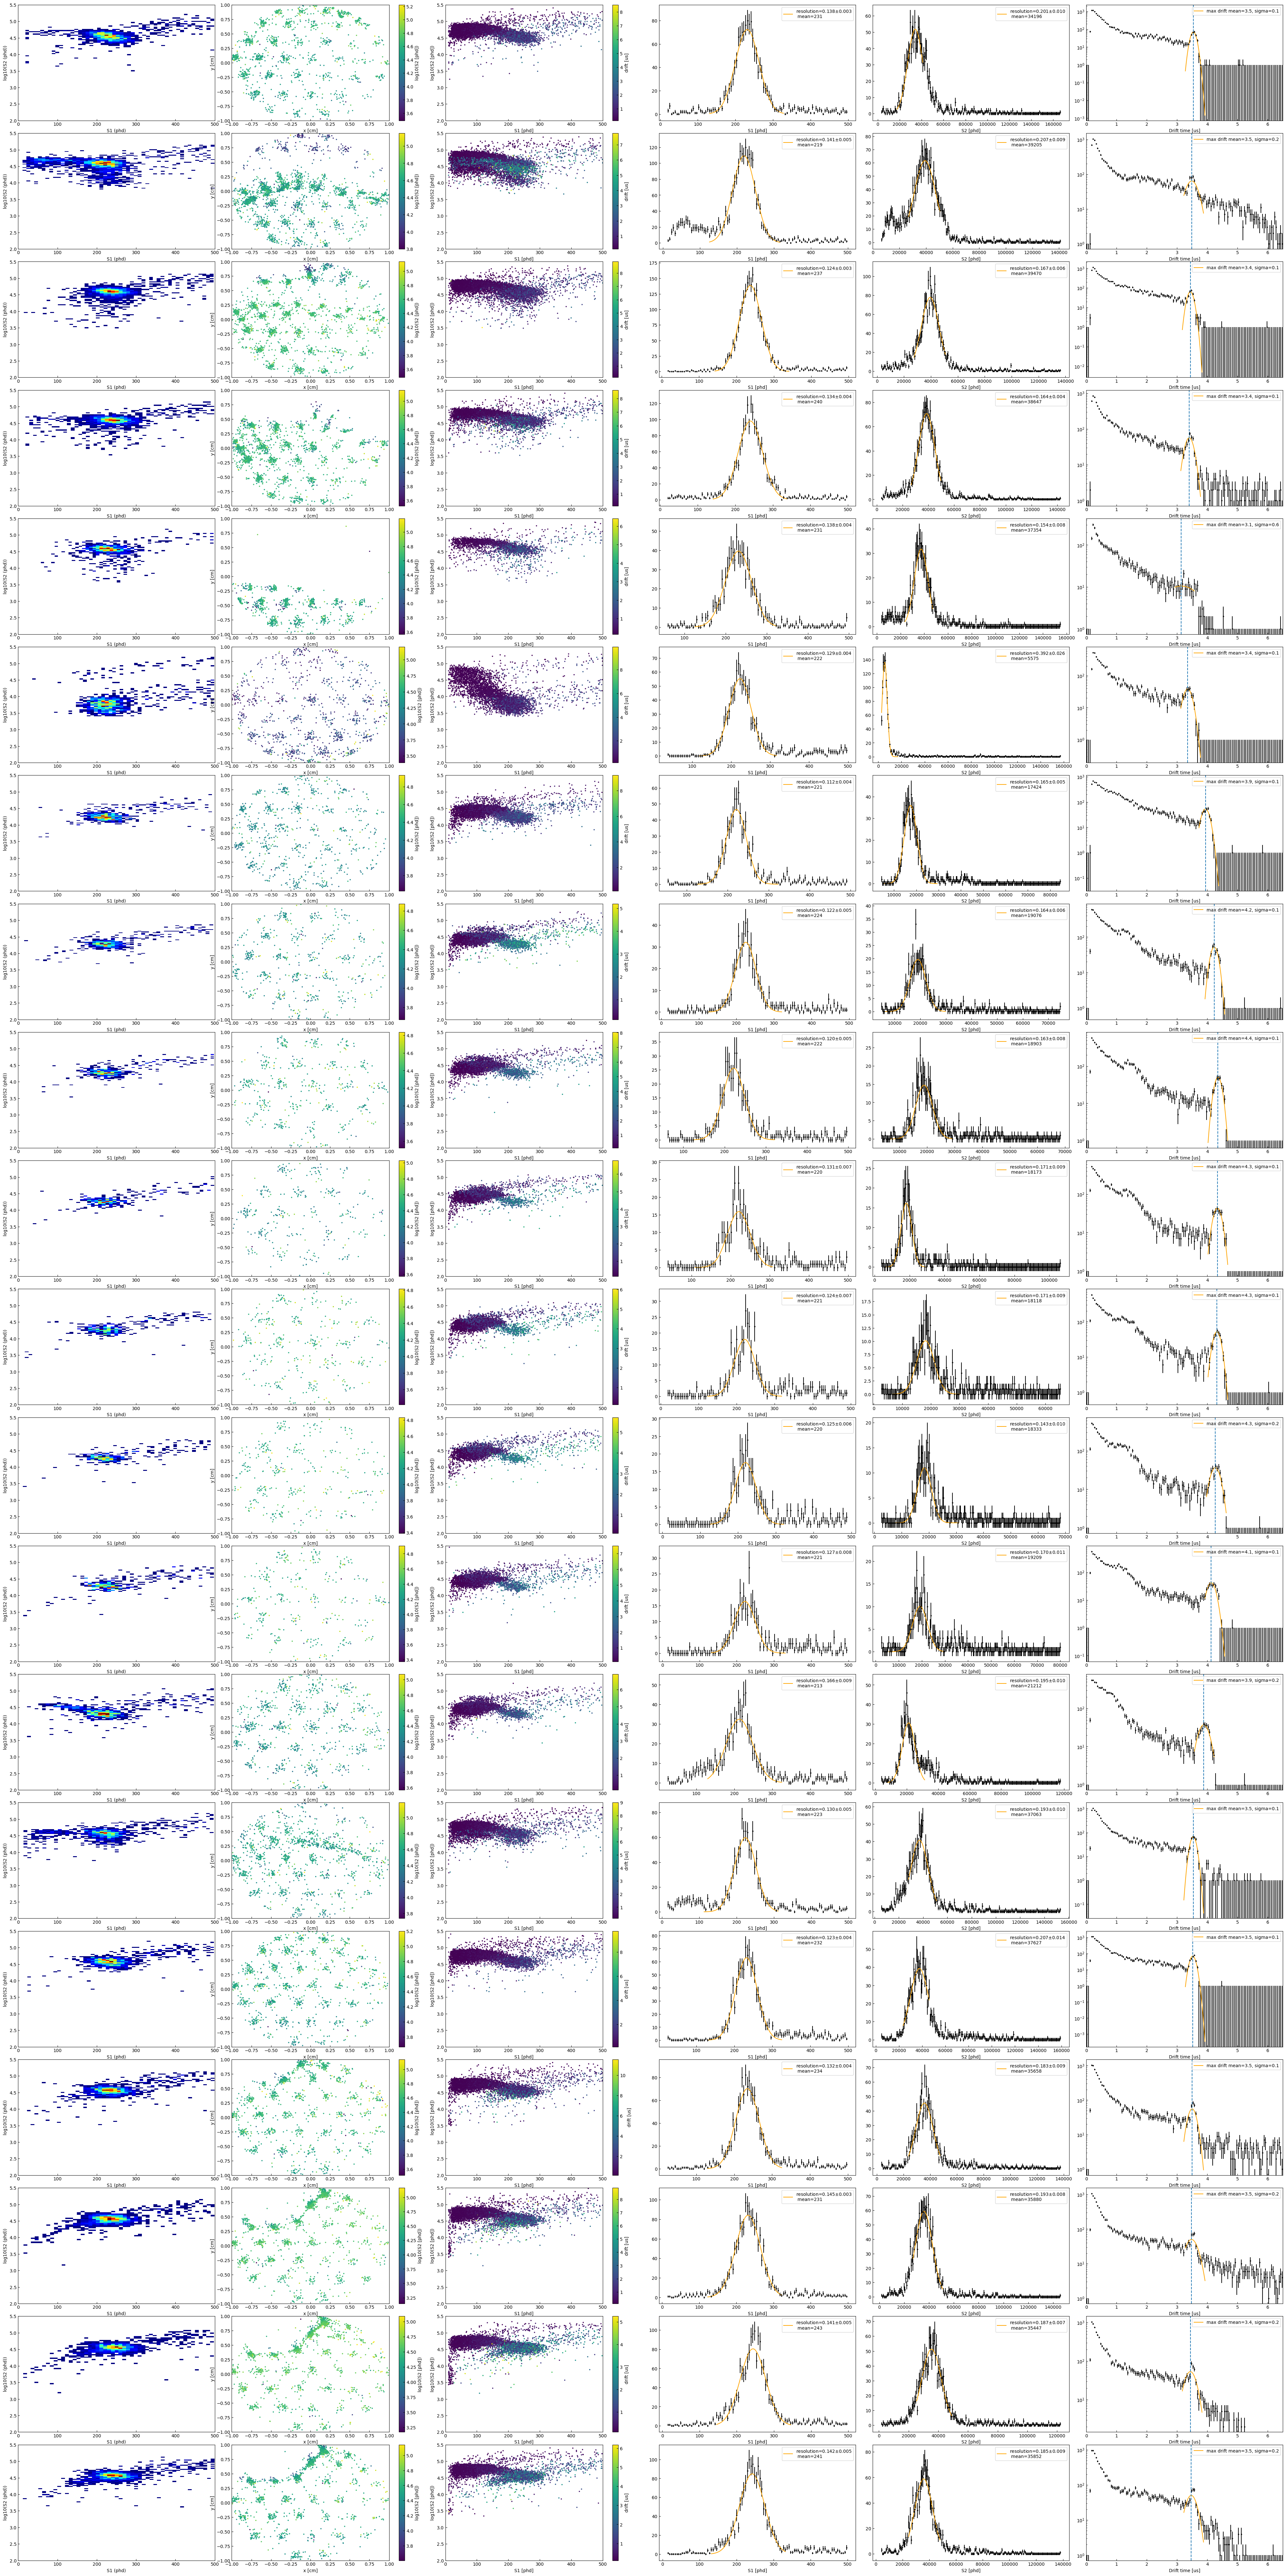

In [2]:
data_dir_Crystals=glob.glob("/media/xaber/extradrive*/crystalize_data/data-202405/2024050*/*/") #data directory
clock_1="220000"   # reference time
date_1 ="20240421" # reference date
time_1 = datetime.strptime(str(date_1)+str(clock_1), "%Y%m%d%H%M%S")
# Get RQ's from dictionary
s1 = np.array([])
s2 = np.array([])
dt = np.array([])
x=np.array([])
y=np.array([])
top_r = np.array([])
s2width=np.array([])
s1_tba=np.array([])
s2_tba=np.array([])

s1_Crystal = np.array([])
s2_Crystal = np.array([])
dt_Crystal = np.array([])
x_Crystal=np.array([])
y_Crystal=np.array([])
top_r_Crystal = np.array([])
s2width_Crystal=np.array([])
s1_tba_Crystal=np.array([])
s2_tba_Crystal=np.array([])
#Crystal data cut
drift_min=1.1 # reset in the loop below, due to the uncertainty in max drift time
drift_max=3
s1max=500
s2min=0
s2max=10**5.5
rcut_max=1
Nrow=len(data_dir_Crystals)
Ncol=6

mean_S1err_lst=[]
mean_S1_lst=[]
mean_S2err_lst=[]
mean_S2_lst=[]
S1res_lst=[]
S1res_err_lst=[]
S2res_lst=[]
S2res_err_lst=[]
res_err_final_lst=[]
res_final_lst=[]
time_lst=[]
maxdrift_lst=[]
maxdrifterr_lst=[]
fig, axs = pl.subplots(Nrow, Ncol, figsize=(40, 40/10*Nrow))
fig.tight_layout()
fitsigma=18000 
j=-1
for i, Crystalfile in enumerate(sorted(data_dir_Crystals)):
    if not os.path.isfile(Crystalfile+"/rq_v1.npy"):continue
    if "SPE" in Crystalfile: continue
    timestr=(Crystalfile.split("/")[-2].split("_")[0])
    time = datetime.strptime(timestr, "%Y%m%d-%H%M%S")
    deltat=(time-time_1).total_seconds()/3600.
    if deltat<0: continue
    print (Crystalfile,deltat)
    j+=1
    data_Crystal = load_run(Crystalfile,rq_file="/rq_v1.npy") 
    ss_data_Crystal = build_ss_dict(data_Crystal)
    s1_Crystal=ss_data_Crystal['s1_area']
    s2_Crystal=ss_data_Crystal['s2_area']
    dt_Crystal=ss_data_Crystal['dt']
    x_Crystal=ss_data_Crystal['s2_top_x']
    y_Crystal=ss_data_Crystal['s2_top_y']
    top_r_Crystal=ss_data_Crystal['s2_top_r']
    s2width_Crystal=ss_data_Crystal['s2_width']
    s1_tba_Crystal=ss_data_Crystal['s1_tba']
    s2_tba_Crystal=ss_data_Crystal['s2_tba']
    
    cut_Crystal2 =(dt_Crystal>0)& (s1_Crystal > 10)&(s2_Crystal > s2min)&(top_r_Crystal < rcut_max)&(top_r_Crystal > 0)&(s1_Crystal<20000)&(s2_Crystal<s2max)
    #drift time histogram for all ROI events
    axs[j,5].set_xlabel("Drift time [us]")
    axs[j,5].set_yscale("log")
    dthist,dtedges=np.histogram(dt_Crystal[cut_Crystal2], bins=200,range=[0,10])
    p03=[np.max(dthist[dtedges[1:]>4]),dtedges[dtedges>2.5][np.argmax(dthist[dtedges[1:]>2.5])],0.35]
    try: # fit a gaussin to the max drift time
        maxdrift,sigma_dt,mean_dterr,sigma_dterr=step_plot_general(dtedges,dthist,p03,fit=True,col='orange',lab="max drift",plot=True,ax=axs[j,5])
    except:
        maxdrift,sigma_dt,mean_dterr,sigma_dterr=step_plot_general(dtedges,dthist,p03,fit=False,col='orange',lab="max drift",plot=True,ax=axs[j,5])
    yrange=axs[j,5].get_ylim()
    axs[j,5].plot([maxdrift,maxdrift],yrange,"--")
    axs[j,5].set_ylim(yrange)
    axs[j,5].set_xlim(0,6.5)
    # set drift time cut based on max drift time
    drift_max=maxdrift*0.86 # upper limit on drift time
    drift_min=maxdrift*0.31 # lower limit on drift time
    if maxdrift>3.9: 
        drift_min=2
    print ("maxdrift, drift time cut",maxdrift, drift_max, drift_min)
    # select ROI events in the drift region
    cut_Crystal = (s1_Crystal > 10)&(s2_Crystal > s2min)&(top_r_Crystal < rcut_max)&(top_r_Crystal > 0)&(s1_Crystal<s1max)&(s2_Crystal<s2max)
    cut_Crystal =cut_Crystal&(dt_Crystal>drift_min)&(dt_Crystal<drift_max)
    # first plot is S1 vs. logS2 in drift region
    hist=axs[j,0].hist2d(s1_Crystal[cut_Crystal], np.log10(s2_Crystal[cut_Crystal]), cmap=pl.cm.jet,bins=(50, 50),cmin=0.1)
    axs[j,0].set_xlabel("S1 (phd)")
    axs[j,0].set_ylabel("log10(S2 (phd))")
    #axs[j,0].set_ylabel("S2 (phd)")
    axs[j,0].set_xlim(0,s1max)
    axs[j,0].set_ylim(2,np.log10(s2max))
    print ("total stats",len(s1_Crystal[cut_Crystal]))
    
    #second plot is x-y in drift region
    sc=axs[j,1].scatter(x_Crystal[cut_Crystal], y_Crystal[cut_Crystal],c=np.log10(s2_Crystal[cut_Crystal]), s=3,marker = 'o')
    axs[j,1].set_xlabel("x [cm]")
    axs[j,1].set_ylabel("y [cm]")
    axs[j,1].set_xlim(-1,1)
    axs[j,1].set_ylim(-1,1)
    fig.colorbar(sc, label="log10(S2 [phd])",orientation='vertical');
    

    #third plot is drift vs. s1 and s2 for all events in the ROI
    cut_Crystal3 = (s1_Crystal > 10)&(s2_Crystal > s2min)&(top_r_Crystal < rcut_max)&(top_r_Crystal > 0)&(s1_Crystal<s1max)&(s2_Crystal<s2max)
    sc=axs[j,2].scatter(s1_Crystal[cut_Crystal3], np.log10(s2_Crystal[cut_Crystal3]),c=dt_Crystal[cut_Crystal3], s=3,marker = 'o')
    axs[j,2].set_xlabel("S1 [phd]")
    axs[j,2].set_ylabel("log10(S2 [phd])")
    axs[j,2].set_xlim(0,s1max)
    axs[j,2].set_ylim(2,np.log10(s2max))
    fig.colorbar(sc, label="drift [us]",orientation='vertical');
    if maxdrift<3 or len(dt_Crystal[cut_Crystal2])<15: 
        continue
    else:
        # scan over rotation angles to find the best energy resolution
        '''res= minimize(minreso, [1.2],bounds=[(0.,np.pi/2.)], method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
        res_final,res_err_final=minreso_plot(res.x[0],axs[j,1])
        #print ("minimization result (solid):",res.x[0])
        #print ("resolution and error (solid):",res_final,res_err_final)
        for theta in np.arange(0.5,1.5,0.01):
            reso=minreso(theta)
            axs[j,2].plot(theta,reso,'k.')
        axs[j,2].plot(res.x[0],res_final,"ro",label="best resolution in solid")
        axs[j,2].legend()
        axs[j,2].set_xlabel("theta")
        axs[j,2].set_ylabel("resolution")'''
        #hist1=axs[j,1].hist2d(s1_Crystal[cut_Crystal], s1_tba_Crystal[cut_Crystal], bins=(100, 100), cmap=pl.cm.jet,cmin=0.1)
        #axs[j,1].set_xlabel("s1area")
        #axs[j,1].set_ylabel("s1tba")
        
        #hist2=axs[j,1].hist2d(s2_Crystal[cut_Crystal], s2_tba_Crystal[cut_Crystal], bins=(100, 100), cmap=pl.cm.jet,cmin=0.1)
        #axs[j,1].set_xlabel("s2area")
        #axs[j,1].set_ylabel("s2tba")
        S1hist,S1edges=np.histogram(s1_Crystal[cut_Crystal], bins=100)
        S2hist,S2edges=np.histogram(s2_Crystal[cut_Crystal], bins=200)
        p0=[np.max(S1hist),S1edges[np.argmax(S1hist)],100] 
        # fourth plot is S1 spectrum
        try:
            mean_S1,sigma_S1,mean_S1err,sigma_S1err=step_plot_general(S1edges,S1hist,p0,fit=True,col='orange',lab="",plot=True,ax=axs[j,3])
        except:
            mean_S1,sigma_S1,mean_S1err,sigma_S1err=step_plot_general(S1edges,S1hist,p0,fit=False,col='orange',lab="",plot=True,ax=axs[j,3])
            continue
        S1res=sigma_S1/mean_S1
        S1res_err=S1res*np.sqrt((mean_S1err/mean_S1)**2+(sigma_S1err/sigma_S1)**2)
        axs[j,3].set_xlabel("S1 [phd]")
        # fifth plot is S2 spectrum
        p02=[np.max(S2hist),S2edges[np.argmax(S2hist)],12000]
        #p02=[np.max(S2hist),S2edges[np.argmax(S2hist)],5000] #sipm 50V
        try:
            mean_S2,sigma_S2,mean_S2err,sigma_S2err=step_plot_general(S2edges,S2hist,p02,fit=True,col='orange',lab="",plot=True,ax=axs[j,4])
        except:
            mean_S2,sigma_S2,mean_S2err,sigma_S2err=step_plot_general(S2edges,S2hist,p02,fit=False,col='orange',lab="",plot=True,ax=axs[j,4])
            continue
        S2res=sigma_S2/mean_S2
        S2res_err=S2res*np.sqrt((mean_S2err/mean_S2)**2+(sigma_S2err/sigma_S2)**2)
        axs[j,4].set_xlabel("S2 [phd]")
        S1res_lst.append(S1res)
        S1res_err_lst.append(S1res_err)
        S2res_lst.append(S2res)
        S2res_err_lst.append(S2res_err)
        #res_final_lst.append(res_final)
        #res_err_final_lst.append(res_err_final)
        time_lst.append(deltat) #time since ref time in h
        mean_S1_lst.append(mean_S1)
        mean_S1err_lst.append(mean_S1err)
        mean_S2_lst.append(mean_S2)
        mean_S2err_lst.append(mean_S2err)
        maxdrift_lst.append(maxdrift)
        maxdrifterr_lst.append(mean_dterr)
# save numbers from the fit 
outfile="signalvstime20240501.npz" 
np.savez(outfile,time_ref=str(time_1),time_lst=time_lst,maxdrift_lst=maxdrift_lst,maxdrifterr_lst=maxdrifterr_lst,mean_S1_lst=mean_S1_lst,mean_S1err_lst=mean_S1err_lst,mean_S2_lst=mean_S2_lst,mean_S2err_lst=mean_S2err_lst,S1res_lst=S1res_lst,S1res_err_lst=S1res_err_lst,S2res_lst=S2res_lst,S2res_err_lst=S2res_err_lst)

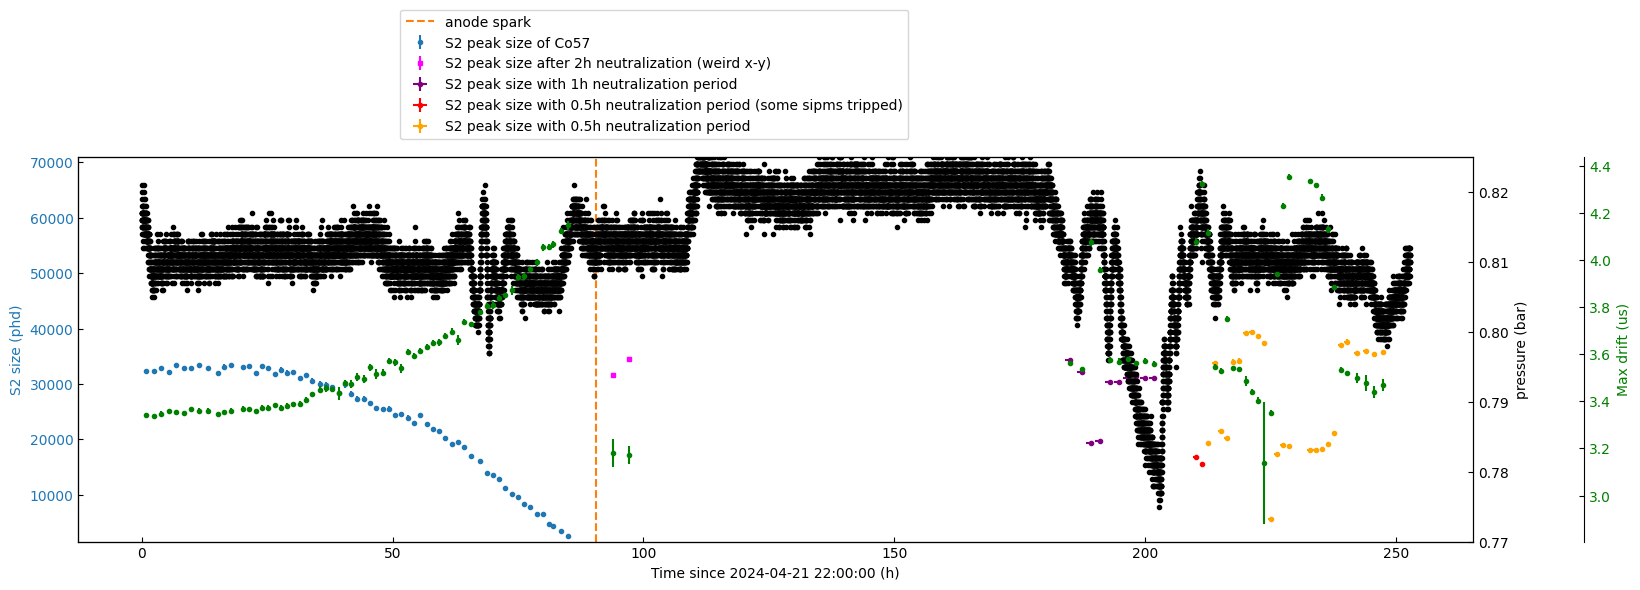

In [4]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.patches import Circle, PathPatch, Rectangle
import time
import matplotlib.colors as mcolors
import glob 
import os.path
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.optimize import minimize
clock_1="220000"
date_1 ="20240421"
time_1 = datetime.strptime(str(date_1)+str(clock_1), "%Y%m%d%H%M%S")
#detfiles=glob.glob("/home/qxia/csvfile/20240318T1428.csv")
#["csvfile/20231127T1732.csv"]+glob.glob("csvfile/20231206*.csv")+glob.glob("csvfile/20231208*.csv")+glob.glob("csvfile/20231209*.csv")+glob.glob("csvfile/20231210*.csv")
detfiles=glob.glob("/home/qxia/csvfile/20240418T1220.csv")
infiles=["signalvstime.npz","signalvstime20240429.npz","signalvstime20240430.npz","signalvstime20240501.npz"]
mean_S1_lst=np.array([])
mean_S1err_lst=np.array([])
time_lst=np.array([])
mean_S2_lst=np.array([])
mean_S2err_lst=np.array([])
maxdrift_lst=np.array([])
maxdrifterr_lst=np.array([])
for filename in infiles:
    infile=np.load(filename)
    mean_S1_lst0=infile["mean_S1_lst"]
    mean_S1err_lst0=infile["mean_S1err_lst"]
    time_lst0=infile["time_lst"]
    mean_S2_lst0=infile["mean_S2_lst"]
    mean_S2err_lst0=infile["mean_S2err_lst"]
    maxdrift_lst0=infile["maxdrift_lst"]
    maxdrifterr_lst0=infile["maxdrifterr_lst"]
    mean_S1_lst=np.concatenate((mean_S1_lst, mean_S1_lst0), axis=None)
    mean_S1err_lst=np.concatenate((mean_S1err_lst, mean_S1err_lst0), axis=None)
    mean_S2_lst=np.concatenate((mean_S2_lst, mean_S2_lst0), axis=None)
    mean_S2err_lst=np.concatenate((mean_S2err_lst, mean_S2err_lst0), axis=None)
    maxdrift_lst=np.concatenate((maxdrift_lst, maxdrift_lst0), axis=None)
    maxdrifterr_lst=np.concatenate((maxdrifterr_lst, maxdrifterr_lst0), axis=None)
    time_lst=np.concatenate((time_lst,time_lst0), axis=None)

plist=[]
tlist=[]
timelist=[]
hmax=500
for detfilename in sorted(detfiles):
    startline=0
    detfile=open(detfilename)
    for line in detfile.readlines()[startline:]:
        date=line.split(",")[0]
        clock=line.split(",")[1]
        t=float(line.split(",")[5])
        p=float(line.split(",")[7])
        time = datetime.strptime(str(date)+str(clock), "%Y%m%d%H%M%S")
        delta=(time-time_1).total_seconds()/3600. #hour
        if delta<0:continue
        if delta>hmax:break
        timelist.append(delta)
        plist.append(p)
        tlist.append(t)

gpts2=(mean_S2_lst>0)&(time_lst<86)
gpts3=(mean_S2_lst>0)&(time_lst>90)&(time_lst<91)
gpts4=(mean_S2_lst>0)&(time_lst>91)&(time_lst<100)
gpts5=(mean_S2_lst>0)&(time_lst>185)&(time_lst<210)
gpts6=(mean_S2_lst>0)&(time_lst>210)
fig=pl.figure(figsize=(18,5))
ax1=pl.gca()
ax1.errorbar(time_lst[gpts2],mean_S2_lst[gpts2],yerr=mean_S2err_lst[gpts2],fmt="o",label="S2 peak size of Co57",markersize=3)
#ax1.errorbar(time_lst[gpts3],mean_S2_lst[gpts3],yerr=mean_S2err_lst[gpts3],fmt="^",label="S2 peak size after anode increase",markersize=3)
ax1.errorbar(time_lst[gpts4],mean_S2_lst[gpts4],yerr=mean_S2err_lst[gpts4],fmt="s",color="magenta",label="S2 peak size after 2h neutralization (weird x-y)",markersize=3)
Nhours = [[1]*len(mean_S2_lst[gpts5]), [0]*len(mean_S2_lst[gpts5])]
Nhours2 = [[0.5]*len(mean_S2_lst[gpts6][:2]), [0]*len(mean_S2_lst[gpts6][:2])]
Nhours3 = [[0.5]*len(mean_S2_lst[gpts6][2:]), [0]*len(mean_S2_lst[gpts6][2:])]
ax1.errorbar(time_lst[gpts5],mean_S2_lst[gpts5],xerr=Nhours, yerr=mean_S2err_lst[gpts5],fmt="o",color="purple",label="S2 peak size with 1h neutralization period",markersize=3)
ax1.errorbar(time_lst[gpts6][:2],mean_S2_lst[gpts6][:2],xerr=Nhours2, yerr=mean_S2err_lst[gpts6][:2],fmt="o",color="red",label="S2 peak size with 0.5h neutralization period (some sipms tripped)",markersize=3)
ax1.errorbar(time_lst[gpts6][2:],mean_S2_lst[gpts6][2:],xerr=Nhours3, yerr=mean_S2err_lst[gpts6][2:],fmt="o",color="orange",label="S2 peak size with 0.5h neutralization period",markersize=3)
ax1.set_xlabel("Time since %s (h)"%time_1)
ax1.set_ylabel("S2 size (phd)",color="tab:blue")
ax2 = ax1.twinx() 
ax2.plot(timelist,plist,"ko",markersize=3)
ax1.set_ylim(min(mean_S2_lst[gpts2])*0.6,max(mean_S2_lst)*1.8)
ax1.plot([time_lst[gpts3][0]]*2,ax1.get_ylim(),"--",label="anode spark")
ax1.legend(loc="best", bbox_to_anchor=(0.6, 1.4))
ax2.set_ylim(0.77,0.825)
color = 'k'
ax2.set_ylabel('pressure (bar)', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax3= ax1.twinx()
ax3.set_ylabel("Max drift (us)",color="g")
ax3.tick_params(axis='y', labelcolor="g")
#ax3.set_ylim(3.32,3.4)
#ax3.errorbar(time_lst[gpts2],maxdrift_lst[gpts2],xerr=[[0]*len(time_lst[gpts2]), [30/60.]*len(time_lst[gpts2])],fmt="o",color="g")
ax3.errorbar(time_lst[gpts2],maxdrift_lst[gpts2],yerr=maxdrifterr_lst[gpts2],fmt="o",color="g",markersize=3)
#ax3.errorbar(time_lst[gpts3],maxdrift_lst[gpts3],yerr=maxdrifterr_lst[gpts3],fmt="o",color="g",markersize=3)
ax3.errorbar(time_lst[gpts4],maxdrift_lst[gpts4],yerr=maxdrifterr_lst[gpts4],fmt="o",color="g",markersize=3)
ax3.errorbar(time_lst[gpts5],maxdrift_lst[gpts5],yerr=maxdrifterr_lst[gpts5],fmt="o",color="g",markersize=3)
ax3.errorbar(time_lst[gpts6],maxdrift_lst[gpts6],yerr=maxdrifterr_lst[gpts6],fmt="o",color="g",markersize=3)
ax3.spines['right'].set_position(('outward', 80))

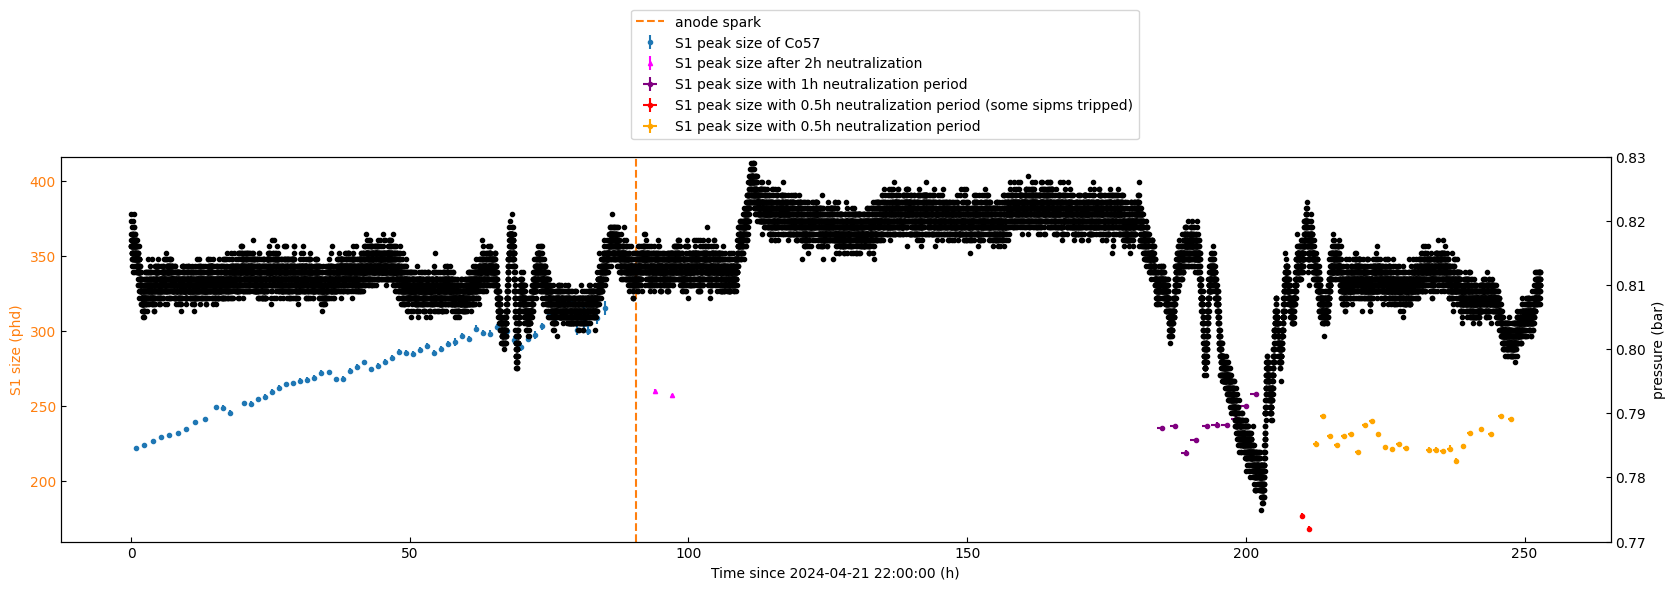

In [5]:
pl.figure(figsize=(20,5))
#gpts2=(mean_S2_lst>0)&(time_lst<86)
#gpts3=(mean_S2_lst>0)&(time_lst>90)&(time_lst<91)
#gpts4=(mean_S2_lst>0)&(time_lst>91)&(time_lst<100)
#gpts5=(mean_S2_lst>0)&(time_lst>125)
pl.errorbar(time_lst[gpts2],mean_S1_lst[gpts2],yerr=mean_S1err_lst[gpts2],fmt="o",label="S1 peak size of Co57",markersize=3)
#pl.errorbar(time_lst[gpts3],mean_S1_lst[gpts3],yerr=mean_S1err_lst[gpts3],fmt="^",label="S1 peak size after anode increase",markersize=3)
pl.errorbar(time_lst[gpts4],mean_S1_lst[gpts4],yerr=mean_S1err_lst[gpts4],fmt="^",color="magenta",label="S1 peak size after 2h neutralization",markersize=3)
pl.errorbar(time_lst[gpts5],mean_S1_lst[gpts5],xerr=Nhours, yerr=mean_S1err_lst[gpts5],fmt="o",color="purple",label="S1 peak size with 1h neutralization period",markersize=3)
pl.errorbar(time_lst[gpts6][:2],mean_S1_lst[gpts6][:2],xerr=Nhours2, yerr=mean_S1err_lst[gpts6][:2],fmt="o",color="red",label="S1 peak size with 0.5h neutralization period (some sipms tripped)",markersize=3)
pl.errorbar(time_lst[gpts6][2:],mean_S1_lst[gpts6][2:],xerr=Nhours3, yerr=mean_S1err_lst[gpts6][2:],fmt="o",color="orange",label="S1 peak size with 0.5h neutralization period",markersize=3)
ax1=pl.gca()
ax1.set_xlabel("Time since %s (h)"%time_1)
ax1.set_ylabel("S1 size (phd)",color="tab:orange")
ax2 = ax1.twinx() 
ax2.plot(timelist,plist,"ko",markersize=3)
ax1.set_ylim(min(mean_S1_lst[gpts6])*0.95,max(mean_S1_lst[gpts2])*1.3)
ax1.plot([time_lst[gpts3][0]]*2,ax1.get_ylim(),"--",label="anode spark")
ax2.set_ylim(0.77,0.83)
color = 'k'
ax2.set_ylabel('pressure (bar)', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='y', labelcolor="tab:orange")
ax1.legend(prop={"size":10}, bbox_to_anchor=(0.7, 1.4))